# Importing Libraries

In [133]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
import re,string,unicodedata

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import os
import warnings

## Dataset Loading

In [134]:
df=pd.read_csv('IMDB Dataset.csv')

In [107]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [108]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

## Data pre-processing

In [110]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [111]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [112]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
df['review']=df['review'].apply(denoise_text)

In [113]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
df['review']=df['review'].apply(remove_special_characters)

In [114]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
df['review']=df['review'].apply(simple_stemmer)

In [116]:
#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
df['review']=df['review'].apply(remove_stopwords)

{'been', 'mustn', 'out', 'being', 'weren', 'haven', 'theirs', 'how', "couldn't", 'was', 'very', 'won', 'again', 'my', 'ma', 'didn', "should've", 'they', "shan't", 'i', 'you', 'am', 'further', 'so', 'of', 'wouldn', 'own', 'while', 'in', 'them', 'm', 'itself', "needn't", 'the', 'y', 'isn', 'yourself', 'those', 'aren', 'hasn', "you've", 'does', 'off', 'yours', 'these', 'ours', "that'll", 'doing', 'hers', 'ourselves', "don't", 'into', 'down', 'its', 'on', 'don', 'against', 'each', 'there', 'below', 's', 'themselves', 'shan', 'what', 'we', 'or', 'both', "it's", 'who', 'here', "you'll", "won't", "aren't", 'an', 'over', 'and', 'it', 've', 'nor', "hasn't", 'needn', "weren't", "didn't", 'their', 'just', 'be', 'our', 'with', 'because', 'once', 'for', 'ain', 'under', 'your', 'as', "isn't", 'which', 'o', 're', 'until', 'should', 'by', 'same', 'hadn', 'is', 'himself', 'when', "haven't", 'too', 'has', 'him', 'do', 'that', 'myself', 'all', 'other', 'herself', 'such', 'd', 'up', "wouldn't", 'but', 'af

## EDA

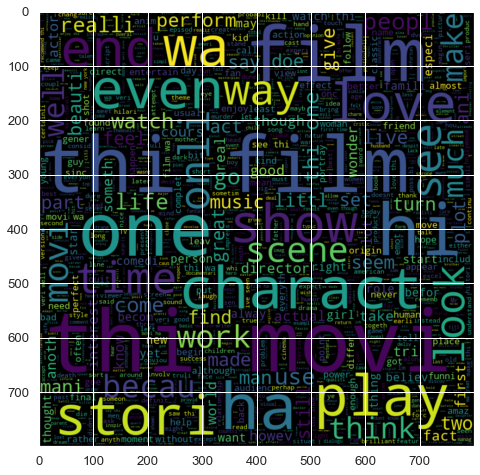

In [122]:
plt.figure(figsize = (8,8)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 800 , height = 800).generate(" ".join(
df[df.sentiment == "positive"].review))
plt.imshow(wc , interpolation = 'bilinear')

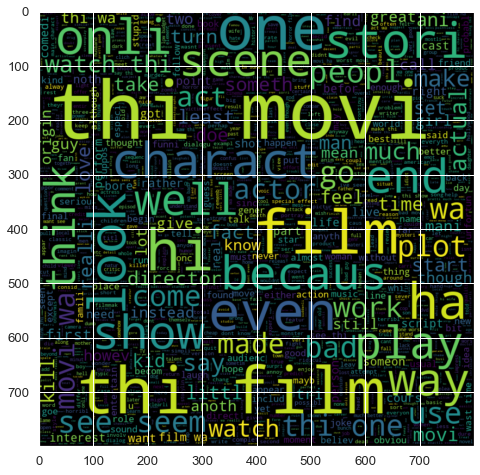

In [123]:
plt.figure(figsize = (8,8)) # Negative Review Text
wc = WordCloud(max_words = 2000 , width = 800 , height = 800).generate(" ".join(
df[df.sentiment == "negative"].review))
plt.imshow(wc , interpolation = 'bilinear')

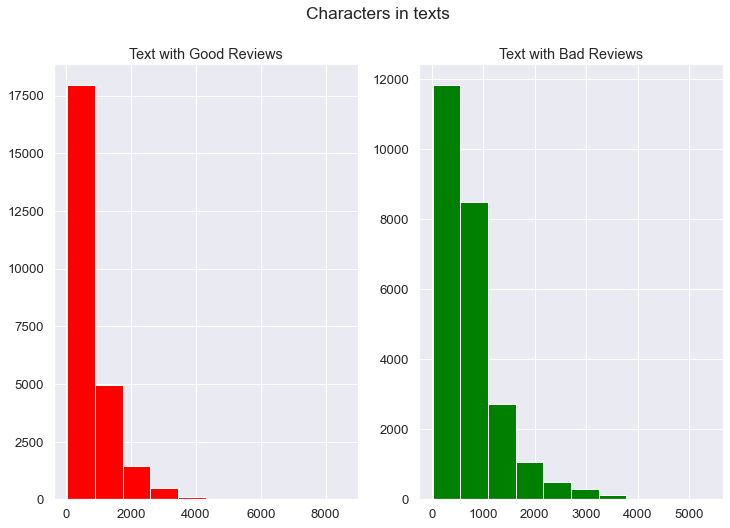

In [124]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['sentiment']=="positive"]['review'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Text with Good Reviews')
text_len=df[df['sentiment']=="negative"]['review'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Characters in texts')
plt.show()

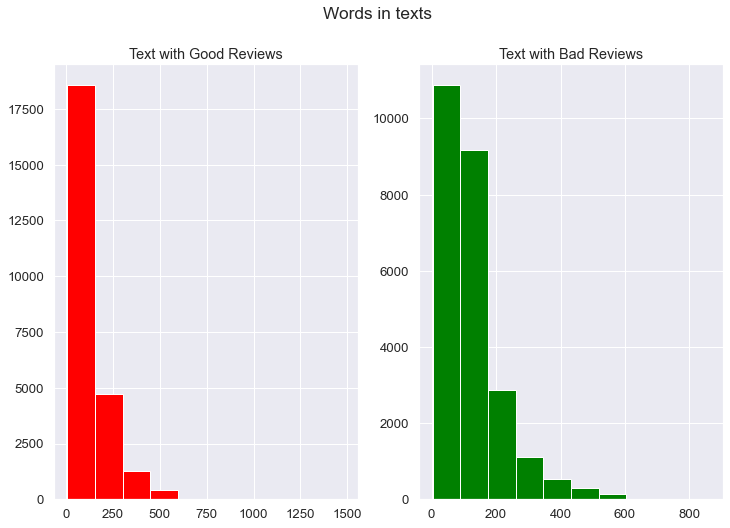

In [125]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['sentiment']=="positive"]['review'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Text with Good Reviews')
text_len=df[df['sentiment']=="negative"]['review'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Words in texts')
plt.show()

In [126]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [127]:
most_common_uni = get_top_text_ngrams(df.review,20,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [130]:
most_common_bi = get_top_text_ngrams(df.review,20,2)
most_common_bi = dict(most_common_bi)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_bi.keys())
temp["Count"] = list(most_common_bi.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Bigrams in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [131]:
most_common_tri = get_top_text_ngrams(df.review,20,3)
most_common_tri = dict(most_common_tri)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_tri.keys())
temp["Count"] = list(most_common_tri.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Trigrams in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

## Data Splitting

In [70]:
#From sklearn.model_selection importing stratifiedShuffleSplit.
from sklearn.model_selection import StratifiedShuffleSplit
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=7)
train_index, test_index = list(stratified_splitter.split(df, df["sentiment"]))[0] 
strat_train_set = df.loc[train_index]
strat_test_set = df.loc[test_index]
print(f"{strat_train_set.shape[0]} train and {strat_test_set.shape[0]} test instances")

37500 train and 12500 test instances


In [71]:
#Rename the dataset to train_data and test_data respectively.
train_data = strat_train_set 
test_data = strat_test_set

In [74]:
test_data.reset_index(drop = True, inplace=True)
 

review sentiment
0  along minor flaw thi film masterpiec definit b...  positive
1  although big coen brother fan admir dark humor...  negative
2  found dominion lousi attempt continu success s...  negative
3  murder number one movi expect madefortv isnt c...  negative
4  thi anoth film rememb wa kid recent manag acqu...  negative

## Modelling

In [75]:
# Lemmatization

def lemmatizingText(review):
    review = review.split()  

    # Removing Stopwords and Lemmatization
    lmtzr = WordNetLemmatizer()
    stopword = set(stopwords.words('english'))
    review = [lmtzr.lemmatize(word, 'v') for word in review if not word in stopword]
    return ' '.join(review)    

train_data['lemma_text'] = train_data.review.apply(lambda x: lemmatizingText(x))
test_data['lemma_text'] = test_data.review.apply(lambda x: lemmatizingText(x))

In [76]:
corpus = train_data.lemma_text.values

In [77]:
# Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(1,3), max_features = 1500)

X_bow = cv.fit_transform(corpus).toarray()
y_bow = train_data.sentiment.values

print('bowtrain_rev:',X_bow.shape)
#print('bowtest_rev:',cvtest_rev.shape)

X_test_bow = cv.transform(test_data.lemma_text.values).toarray()
y_test_bow = test_data.sentiment.values

bowtrain_rev: (37500, 1500)


## Naive Bayes

In [78]:
# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import GaussianNB

# Creating Naive Bayes classifier for BOW
nb_clf = GaussianNB()

# Fitting the training set into the Naive Bayes classifier
nb_clf.fit(X_bow, y_bow)
print('Train Score: ',nb_clf.score(X_bow,y_bow) *100,'%')
print('Test Score: ',nb_clf.score(X_test_bow,y_test_bow)*100,'%')

Train Score:  80.872 %
Test Score:  80.536 %


              precision    recall  f1-score   support

    negative       0.79      0.84      0.81      6250
    positive       0.82      0.78      0.80      6250

    accuracy                           0.81     12500
   macro avg       0.81      0.81      0.81     12500
weighted avg       0.81      0.81      0.81     12500



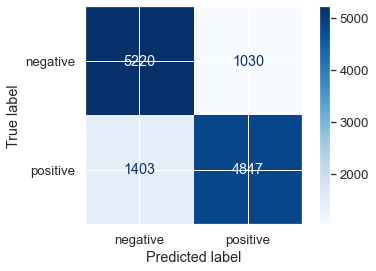

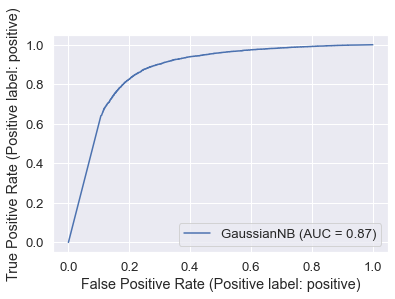

In [79]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report
print(classification_report(y_test_bow,nb_clf.predict(X_test_bow)))
plot_confusion_matrix(nb_clf, X_test_bow, y_test_bow, cmap='Blues')
plt.show()
plot_roc_curve(nb_clf, X_test_bow, y_test_bow)
plt.show()

## Multinomial Naive Bayes

In [80]:
from sklearn.naive_bayes import MultinomialNB

# Creating  multinomial Naive Bayes classifier
mnb_clf = MultinomialNB()

# Fitting the training set into the multinomial Naive Bayes classifier
mnb_clf.fit(X_bow, y_bow)
print('Train Score: ',mnb_clf.score(X_bow,y_bow) *100,'%')
print('Test Score: ',mnb_clf.score(X_test_bow,y_test_bow)*100,'%')

Train Score:  82.896 %
Test Score:  83.336 %


              precision    recall  f1-score   support

    negative       0.83      0.83      0.83      6250
    positive       0.83      0.83      0.83      6250

    accuracy                           0.83     12500
   macro avg       0.83      0.83      0.83     12500
weighted avg       0.83      0.83      0.83     12500



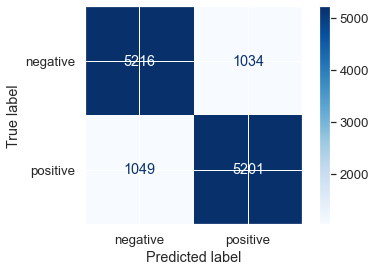

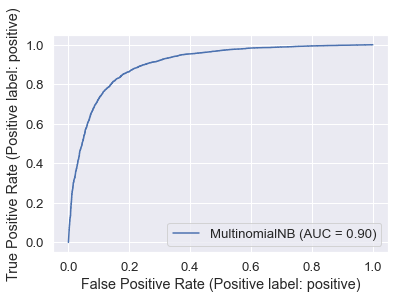

In [81]:
print(classification_report(y_test_bow,mnb_clf.predict(X_test_bow)))
plot_confusion_matrix(mnb_clf, X_test_bow, y_test_bow, cmap='Blues')
plt.show()
plot_roc_curve(mnb_clf, X_test_bow, y_test_bow)
plt.show()

## Logistic Regression

In [82]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()

# Fitting the training set to the logistic Regression
lr_clf.fit(X_bow, y_bow)
print('Train Score: ',lr_clf.score(X_bow,y_bow) *100,'%')
print('Test Score: ',lr_clf.score(X_test_bow,y_test_bow)*100,'%')

/Users/piyushchaudhary/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Score:  88.656 %
Test Score:  87.08 %


              precision    recall  f1-score   support

    negative       0.87      0.87      0.87      6250
    positive       0.87      0.87      0.87      6250

    accuracy                           0.87     12500
   macro avg       0.87      0.87      0.87     12500
weighted avg       0.87      0.87      0.87     12500



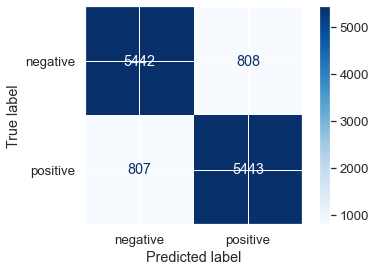

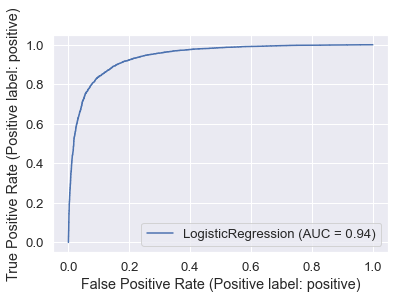

In [83]:
print(classification_report(y_test_bow,lr_clf.predict(X_test_bow)))
plot_confusion_matrix(lr_clf, X_test_bow, y_test_bow, cmap='Blues')
plt.show()
plot_roc_curve(lr_clf, X_test_bow, y_test_bow)
plt.show()

## Decision Tree

In [84]:
from sklearn.tree import DecisionTreeClassifier

#creating decision tree classifier
tree_clf = DecisionTreeClassifier()

# Fitting the training set into the decision tree classifier
tree_clf.fit(X_bow, y_bow)
print('Train Score: ',tree_clf.score(X_bow,y_bow) *100,'%')
print('Test Score: ',tree_clf.score(X_test_bow,y_test_bow)*100,'%')

Train Score:  100.0 %
Test Score:  72.088 %


              precision    recall  f1-score   support

    negative       0.72      0.72      0.72      6250
    positive       0.72      0.72      0.72      6250

    accuracy                           0.72     12500
   macro avg       0.72      0.72      0.72     12500
weighted avg       0.72      0.72      0.72     12500



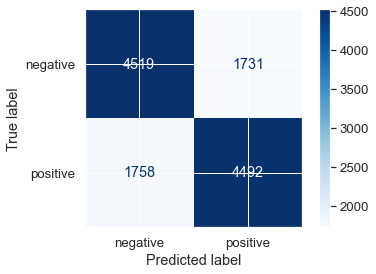

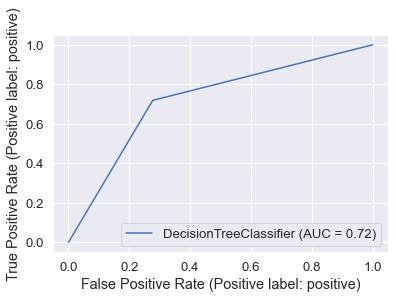

In [85]:
print(classification_report(y_test_bow,tree_clf.predict(X_test_bow)))
plot_confusion_matrix(tree_clf, X_test_bow, y_test_bow, cmap='Blues')
plt.show()
plot_roc_curve(tree_clf, X_test_bow, y_test_bow)
plt.show()

## Support Vector Machine

In [87]:
#training the linear svm
svm=SGDClassifier()
#fitting the svm for bag of words
svm.fit(X_bow, y_bow)
print('Train Score: ',svm.score(X_bow,y_bow) *100,'%')
print('Test Score: ',svm.score(X_test_bow,y_test_bow)*100,'%')

Train Score:  88.384 %
Test Score:  86.96000000000001 %


              precision    recall  f1-score   support

    negative       0.86      0.89      0.87      6250
    positive       0.89      0.85      0.87      6250

    accuracy                           0.87     12500
   macro avg       0.87      0.87      0.87     12500
weighted avg       0.87      0.87      0.87     12500



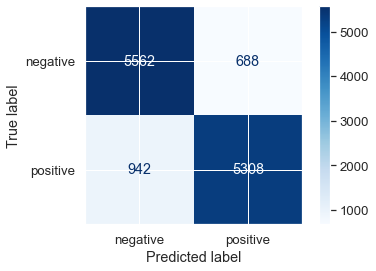

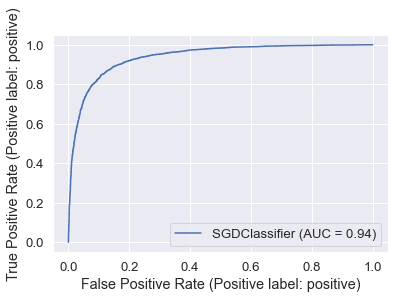

In [88]:
print(classification_report(y_test_bow,svm.predict(X_test_bow)))
plot_confusion_matrix(svm, X_test_bow, y_test_bow, cmap='Blues')
plt.show()
plot_roc_curve(svm, X_test_bow, y_test_bow)
plt.show()

## Random Forest

In [89]:
from sklearn.ensemble import RandomForestClassifier

#creating random forest classifier
rf = RandomForestClassifier()

#Fitting the training set into the random forest classifier
rf.fit(X_bow, y_bow)
print('Train Score: ',rf.score(X_bow,y_bow) *100,'%')
print('Test Score: ',rf.score(X_test_bow,y_test_bow)*100,'%')

Train Score:  100.0 %
Test Score:  83.544 %


              precision    recall  f1-score   support

    negative       0.83      0.84      0.84      6250
    positive       0.84      0.83      0.84      6250

    accuracy                           0.84     12500
   macro avg       0.84      0.84      0.84     12500
weighted avg       0.84      0.84      0.84     12500



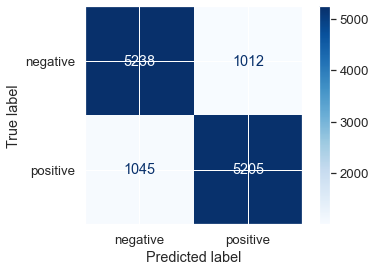

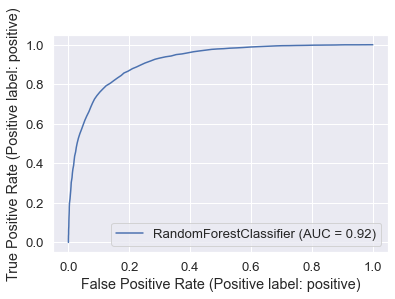

In [90]:
print(classification_report(y_test_bow,rf.predict(X_test_bow)))
plot_confusion_matrix(rf, X_test_bow, y_test_bow, cmap='Blues')
plt.show()
plot_roc_curve(rf, X_test_bow, y_test_bow)
plt.show()

## Result Comparision

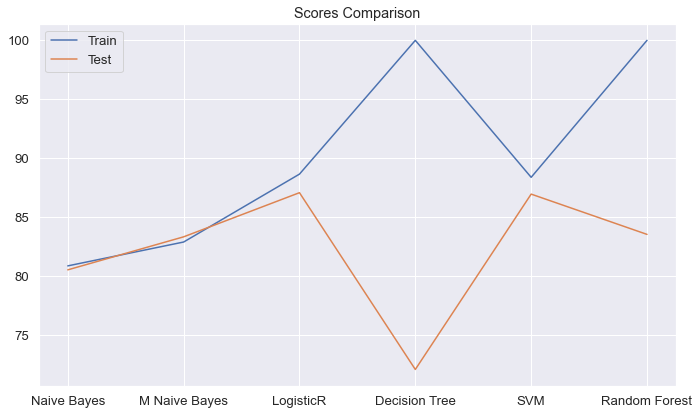

In [91]:
train_scores = [nb_clf.score(X_bow,y_bow) *100,mnb_clf.score(X_bow,y_bow) *100,lr_clf.score(X_bow,y_bow) *100,tree_clf.score(X_bow,y_bow) *100,svm.score(X_bow,y_bow) *100,rf.score(X_bow,y_bow) *100]
test_scores = [nb_clf.score(X_test_bow,y_test_bow) *100,mnb_clf.score(X_test_bow,y_test_bow) *100,
              lr_clf.score(X_test_bow,y_test_bow) *100,tree_clf.score(X_test_bow,y_test_bow) *100,
              svm.score(X_test_bow,y_test_bow) *100,rf.score(X_test_bow,y_test_bow) *100]

models = ['Naive Bayes', 'M Naive Bayes', 'LogisticR','Decision Tree','SVM','Random Forest']

plt.figure(figsize=(10,6))
plt.plot(models,train_scores)
# plt.bar(models,train_scores)
plt.plot(models,test_scores)
# plt.bar(models,test_scores)
plt.legend(['Train','Test'])
plt.title('Scores Comparison')
plt.tight_layout()

## Logistic Regression with hyper parameter tunning

In [96]:
#Importing Grid search library functions for hyper parameter tuning
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression
# specifying the hyperparameter 
grid={"C":[100,10,1.0,0.1,0.01],"penalty":["l1","l2"]}# l1 lasso l2 ridge
#loading LogisticRegression
logreg=LogisticRegression()
# 5 fold cross validation used
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(X_bow,y_bow)
print('Train Score: ',logreg_cv.score(X_bow,y_bow) *100,'%')
print('Test Score: ',logreg_cv.score(X_test_bow,y_test_bow)*100,'%')

/Users/piyushchaudhary/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/piyushchaudhary/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/piyushchaudhary/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/piyushchaudhary/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score o

/Users/piyushchaudhary/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/piyushchaudhary/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/piyushchaudhary/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/piyushchaudhary/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score o

/Users/piyushchaudhary/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/piyushchaudhary/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/piyushchaudhary/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/piyushchaudhary/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score o

/Users/piyushchaudhary/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/piyushchaudhary/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Train Score:  88.21333333333334 %
Test Score:  87.384 %


              precision    recall  f1-score   support

    negative       0.88      0.87      0.87      6250
    positive       0.87      0.88      0.87      6250

    accuracy                           0.87     12500
   macro avg       0.87      0.87      0.87     12500
weighted avg       0.87      0.87      0.87     12500



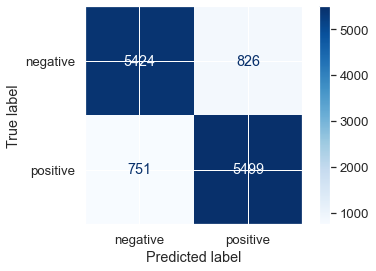

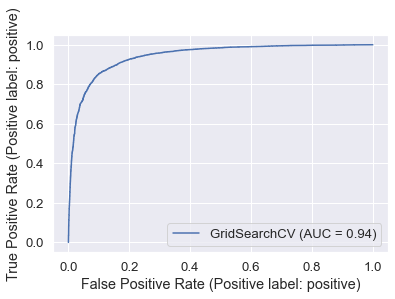

In [97]:
print(classification_report(y_test_bow,logreg_cv.predict(X_test_bow)))
plot_confusion_matrix(logreg_cv, X_test_bow, y_test_bow, cmap='Blues')
plt.show()
plot_roc_curve(logreg_cv, X_test_bow, y_test_bow)
plt.show()

## SVM with Hyper parameter tuning

In [100]:
#Importing Grid search
from sklearn.model_selection import GridSearchCV #Importing Linear svc
from sklearn.svm import LinearSVC 
lsvm = LinearSVC()
# specify the hyperparameters and their values # 5 combinations in the grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 3, 5],
    'max_iter': [5000],
    'random_state': [7]
}
# we'll use 5-fold cross-validation
l_grid_search = GridSearchCV(lsvm, param_grid, cv=2)
l_grid_search.fit(X_bow, y_bow) 
print('Train Score: ',l_grid_search.score(X_bow,y_bow) *100,'%')
print('Test Score: ',l_grid_search.score(X_test_bow,y_test_bow)*100,'%')

/Users/piyushchaudhary/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/piyushchaudhary/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/piyushchaudhary/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/piyushchaudhary/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/piyushchaudhary/opt/anaconda3/lib/python3.8/site-packages

Train Score:  88.16533333333332 %
Test Score:  87.344 %


              precision    recall  f1-score   support

    negative       0.88      0.86      0.87      6250
    positive       0.87      0.88      0.87      6250

    accuracy                           0.87     12500
   macro avg       0.87      0.87      0.87     12500
weighted avg       0.87      0.87      0.87     12500



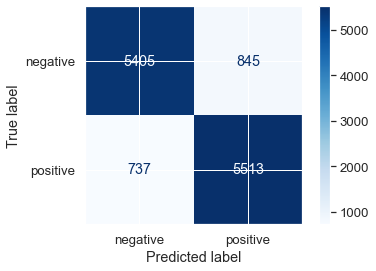

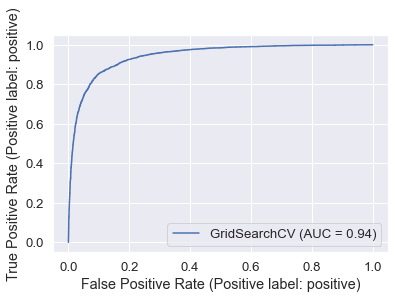

In [101]:
print(classification_report(y_test_bow,l_grid_search.predict(X_test_bow)))
plot_confusion_matrix(l_grid_search, X_test_bow, y_test_bow, cmap='Blues')
plt.show()
plot_roc_curve(l_grid_search, X_test_bow, y_test_bow)
plt.show()